In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from glob import glob
encounters=pd.read_hdf('encounters.hdf','encounters')
alldata = pd.read_hdf('alldata.hdf','alldata')

In [2]:
print("Number of encounters before averaging: %10d" % len(encounters))

################################
#GROUP AVERAGE OUR DATA INTO 30 MIN CHUNKS
temp = []
for sidA in np.unique(encounters['deviceid_sensorA']):
    for sidB in np.unique(encounters['deviceid_sensorB']):
        enc = encounters[(encounters['deviceid_sensorA']==sidA) & (encounters['deviceid_sensorB']==sidB)]
        #enc=enc.dropna(how='any',subset=['pm2_5_sensorA','pm2_5_sensorB'])
        if len(enc)<1:
            continue  
        #temp.append(enc.resample('30min',on='datetime').mean().dropna(0,'all'))
        temp.append(enc.resample('30min',on='datetime').mean().dropna(how='any',subset=['o3_sensorA','o3_sensorB']))
        
        #temp.append(enc.resample('30T',on='datetime').mean())#.dropna(how='any',subset=['pm2_5_sensorA','pm2_5_sensorB']))
    
encounters = pd.concat(temp) 
encounters['datetime']=encounters.index
print("Number of encounters after averaging: %10d" % len(encounters))

Number of encounters before averaging:    2136193
Number of encounters after averaging:     170103


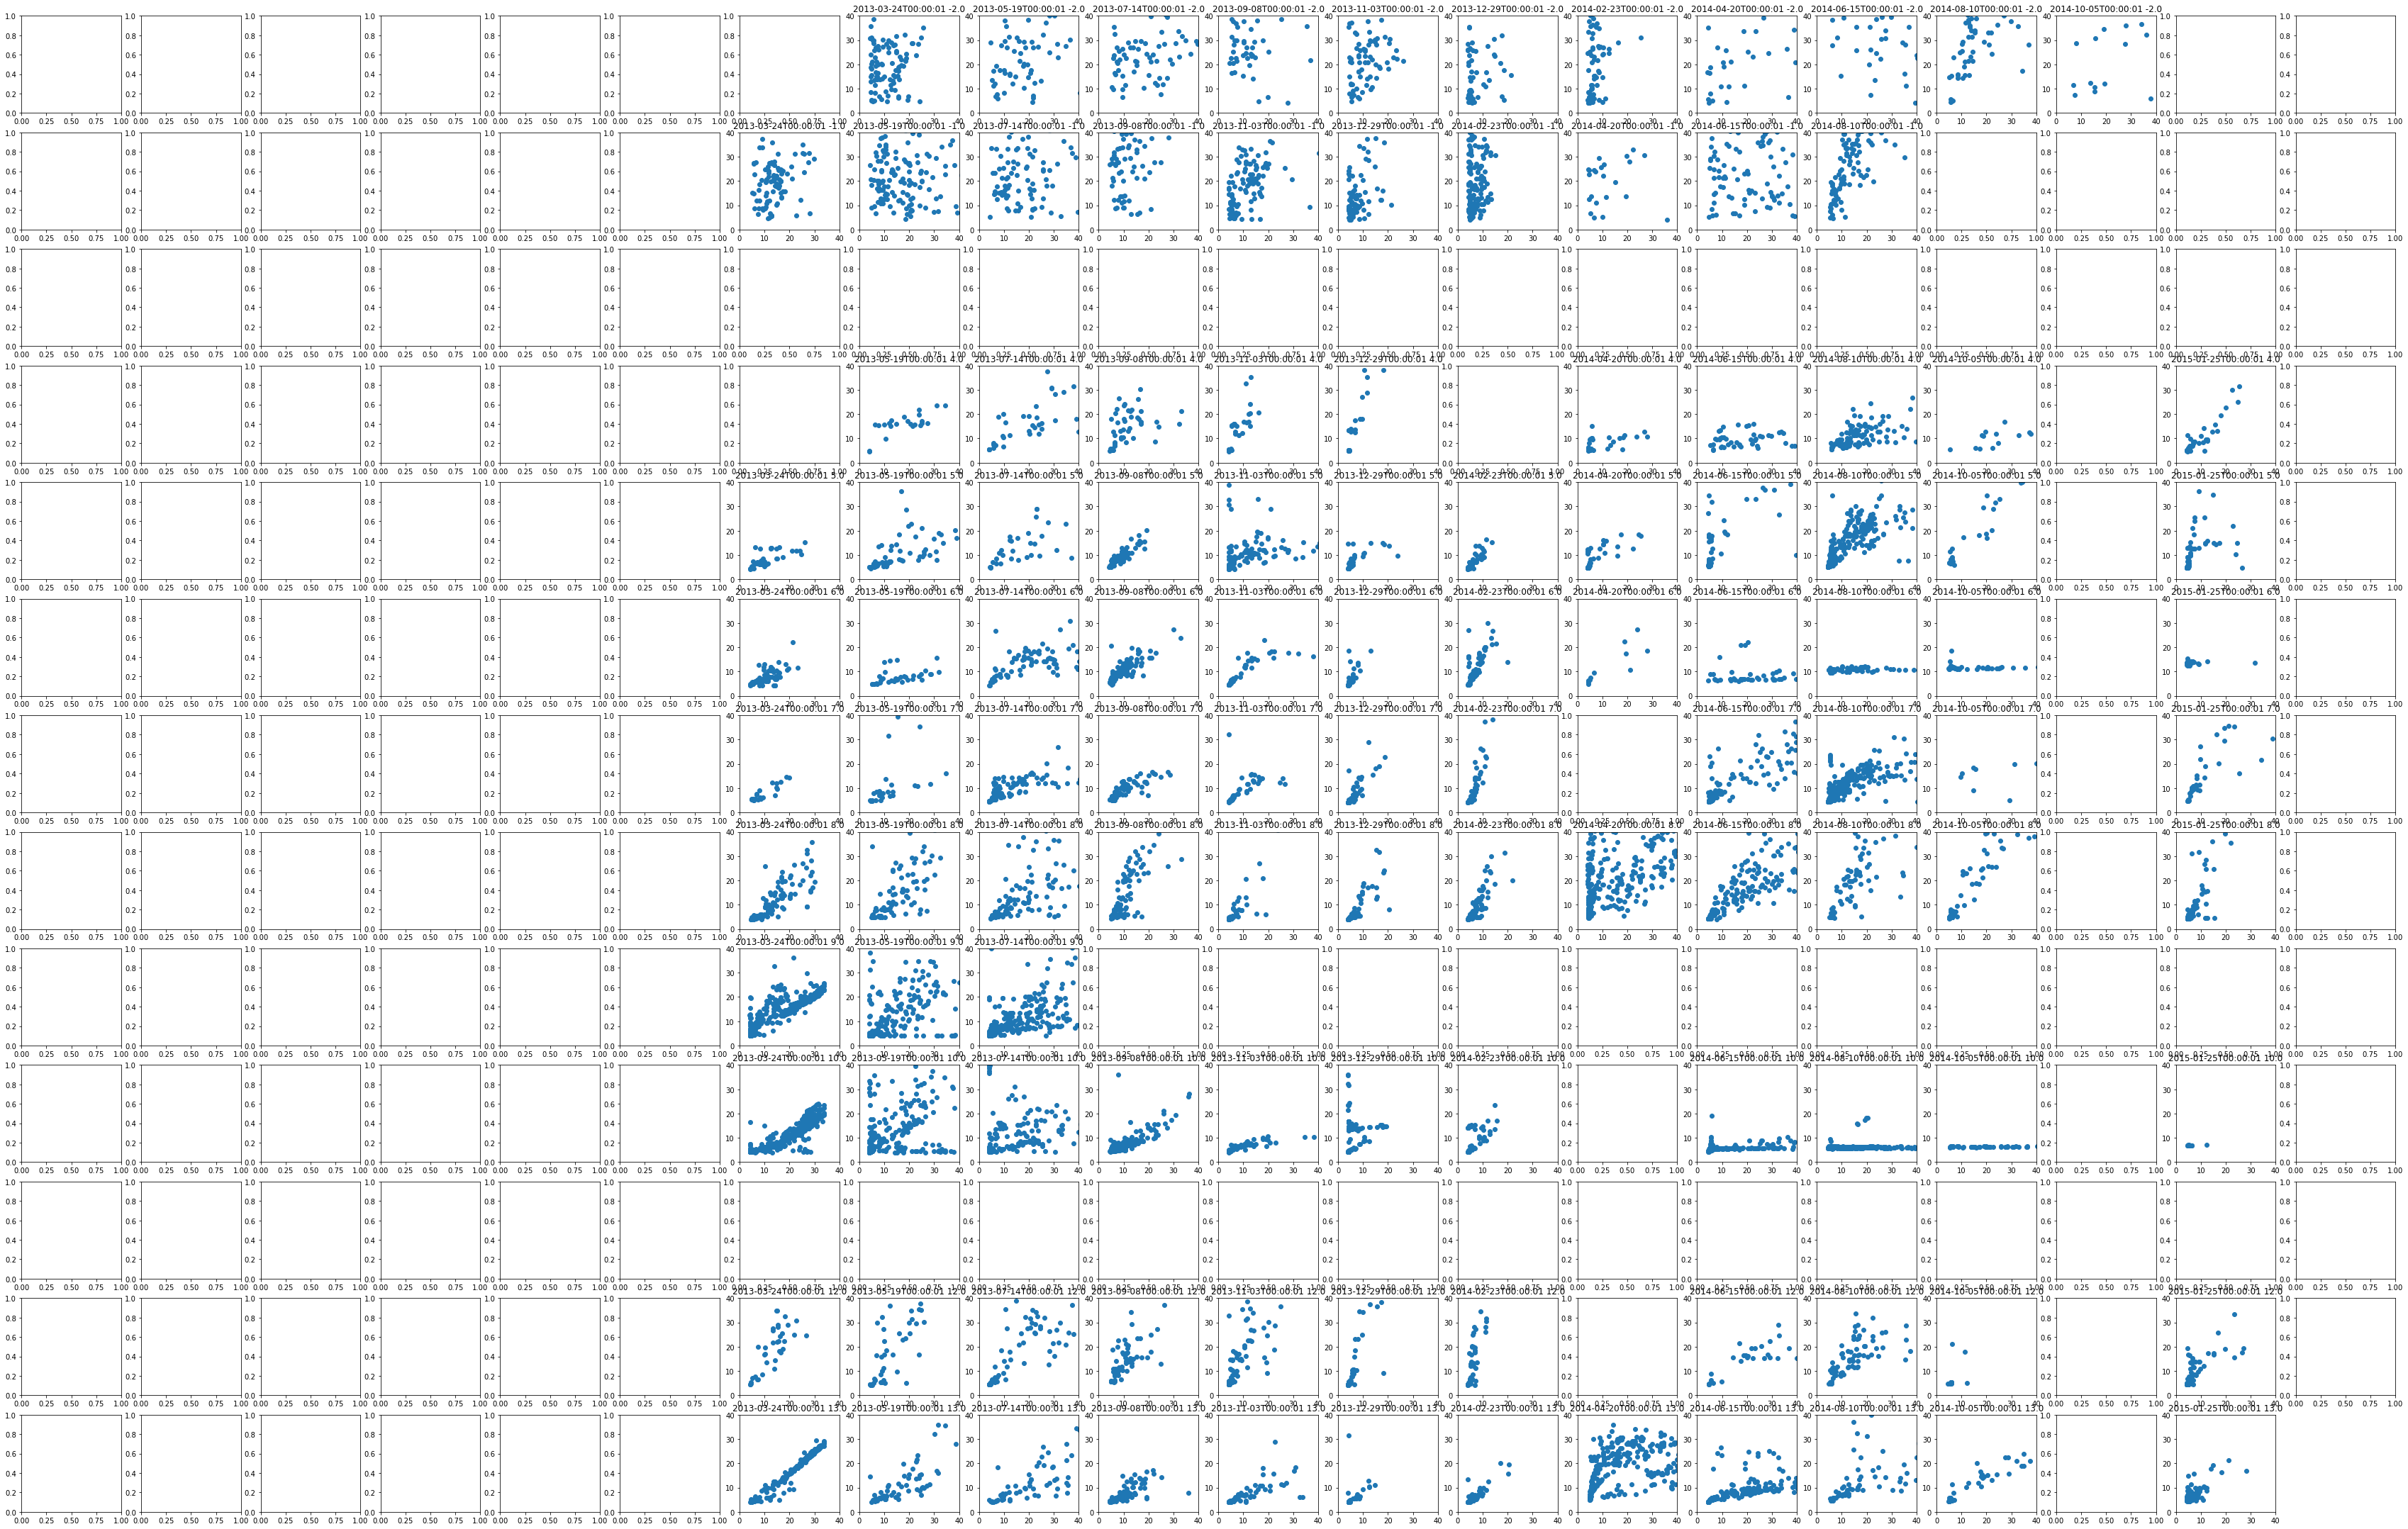

In [3]:

dt = np.timedelta64(8*7*3600*24,'s')
plt.figure(figsize=[60,60])
plti = 1
idA = 11
idB = 8
for idB in np.unique(encounters['deviceid_sensorB']):
    t = np.datetime64('2012-01-01 00:00:01')
    while t<np.datetime64('2018-06-01'):
        enc = encounters[(encounters['datetime']>t) & (encounters['datetime']<t+dt)]
        t=t+dt
        enc = enc[(enc['deviceid_sensorA']==idA) & (enc['deviceid_sensorB']==idB)]
        plt.subplot(20,20,plti)
        plti+=1
        if len(enc)>10:

            plt.scatter(enc['o3_sensorA'],enc['o3_sensorB'])#,5,alpha=1)
            plt.title(str(t)+" "+str(idB))
            plt.xlim([0,40])
            plt.ylim([0,40])
        if plti % 20 == 0:
            break

(array([ 1888.,  4727., 24628., 25183., 25148., 23061., 19460., 26192.,
        15281.,  4535.]),
 array([734535.33333333, 734703.06041667, 734870.7875    , 735038.51458333,
        735206.24166667, 735373.96875   , 735541.69583333, 735709.42291667,
        735877.15      , 736044.87708333, 736212.60416667]),
 <a list of 10 Patch objects>)

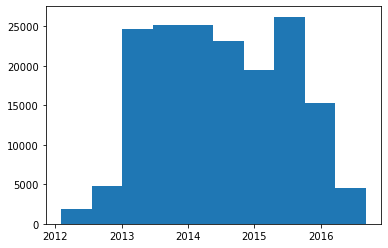

In [4]:
plt.hist(encounters['datetime'])

In [5]:
encounters['dist']

datetime
2012-02-17 23:30:00    15.059389
2012-04-23 04:30:00    45.243375
2013-09-09 14:30:00    18.338289
2013-09-26 23:30:00     7.838845
2013-09-30 16:00:00    11.676633
                         ...    
2016-09-05 04:30:00     3.389760
2016-09-05 05:30:00    30.929530
2016-09-05 06:00:00    35.967822
2016-09-05 06:30:00     8.096398
2016-09-05 10:30:00    33.006821
Name: dist, Length: 170103, dtype: float64

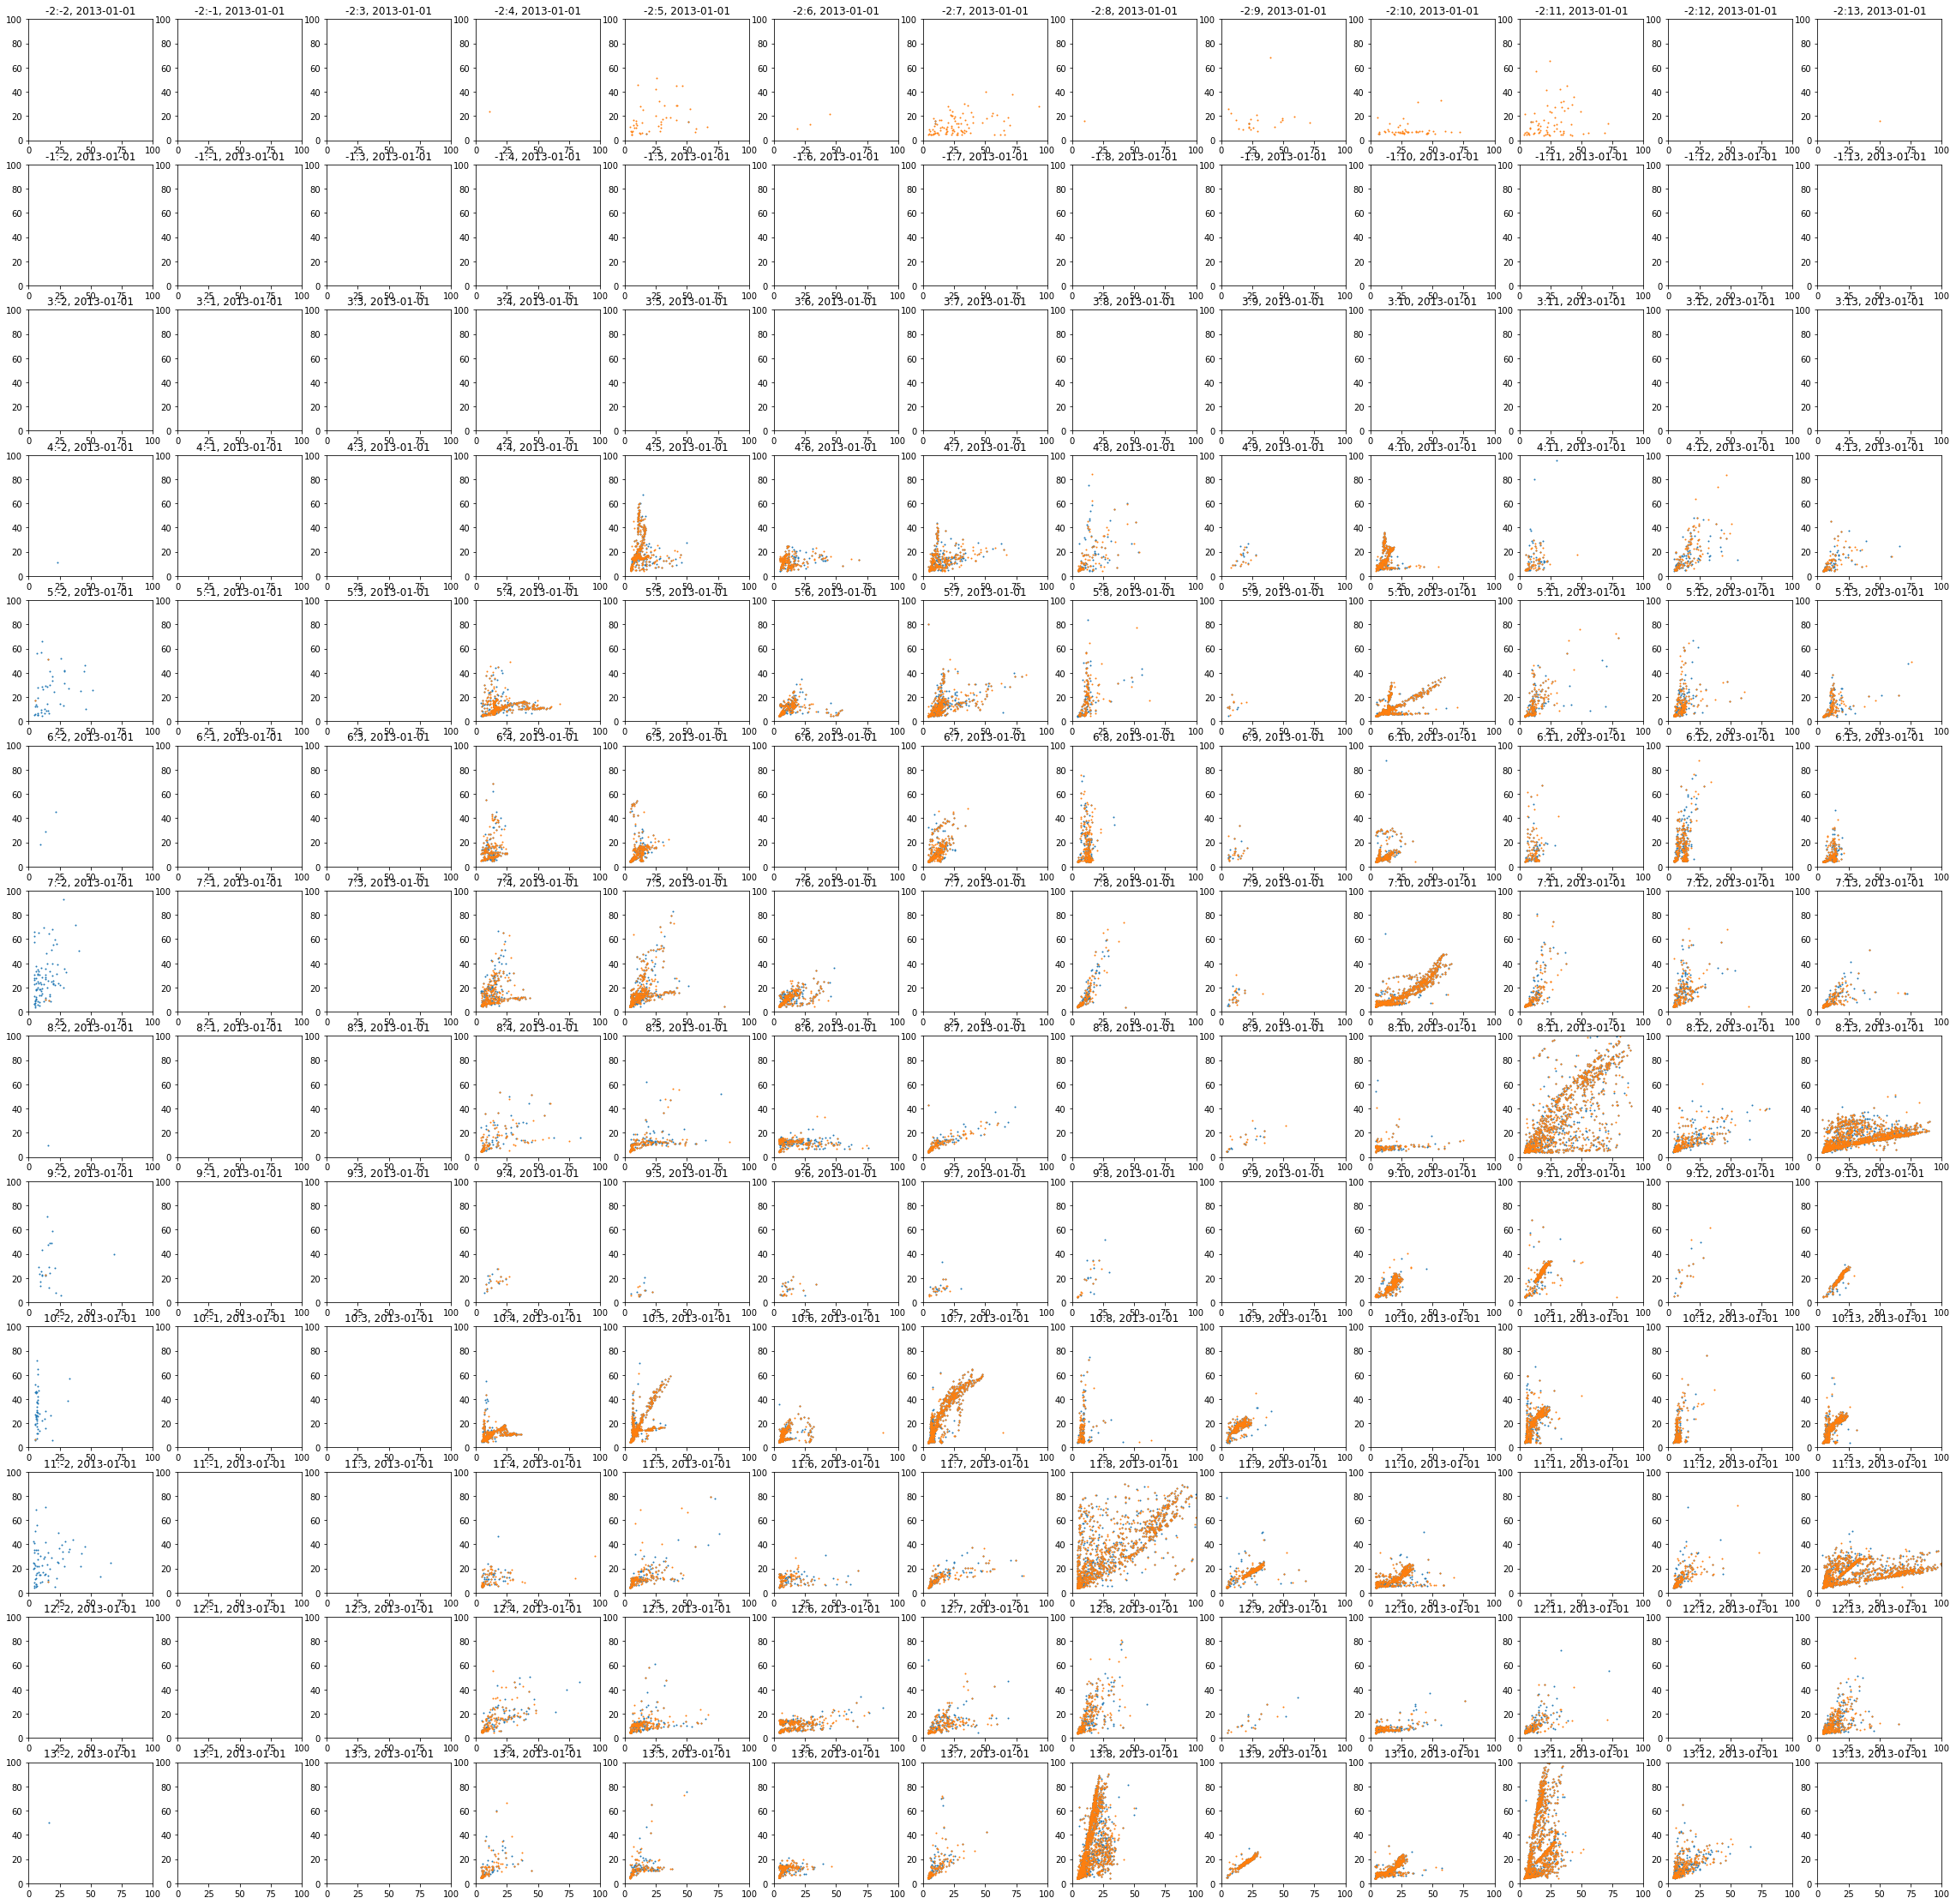

In [6]:
sidAs = sorted(np.unique(encounters['deviceid_sensorA']))
sidBs = sorted(np.unique(encounters['deviceid_sensorB']))

t = np.datetime64('2013-01-01 00:00:01')
dt = np.timedelta64(5000*3600*24,'s')
plt.figure(figsize=[40,40])
plti = 1
for iA,idA in enumerate(sidAs):
    for iB,idB in enumerate(sidBs):
        plt.subplot(len(sidAs),len(sidBs),plti)
        enc = encounters[((encounters['deviceid_sensorA']==idA) & (encounters['deviceid_sensorB']==idB))]
        en = enc[(enc['datetime']>t) & (enc['datetime']<t+dt) & (enc['dist']<10)]
        plt.scatter(en['o3_sensorA'],en['o3_sensorB'],1,alpha=1)

        enc = encounters[((encounters['deviceid_sensorB']==idA) & (encounters['deviceid_sensorA']==idB))]
        en = enc[(enc['datetime']>t) & (enc['datetime']<t+dt) & (enc['dist']<10)]
        plt.scatter(en['o3_sensorB'],en['o3_sensorA'],1,alpha=1)
        plt.title("%d:%d, %s" % (int(idA),idB,str(t)[:10]))
        plt.xlim([0,100])
        plt.ylim([0,100])
        plti+=1

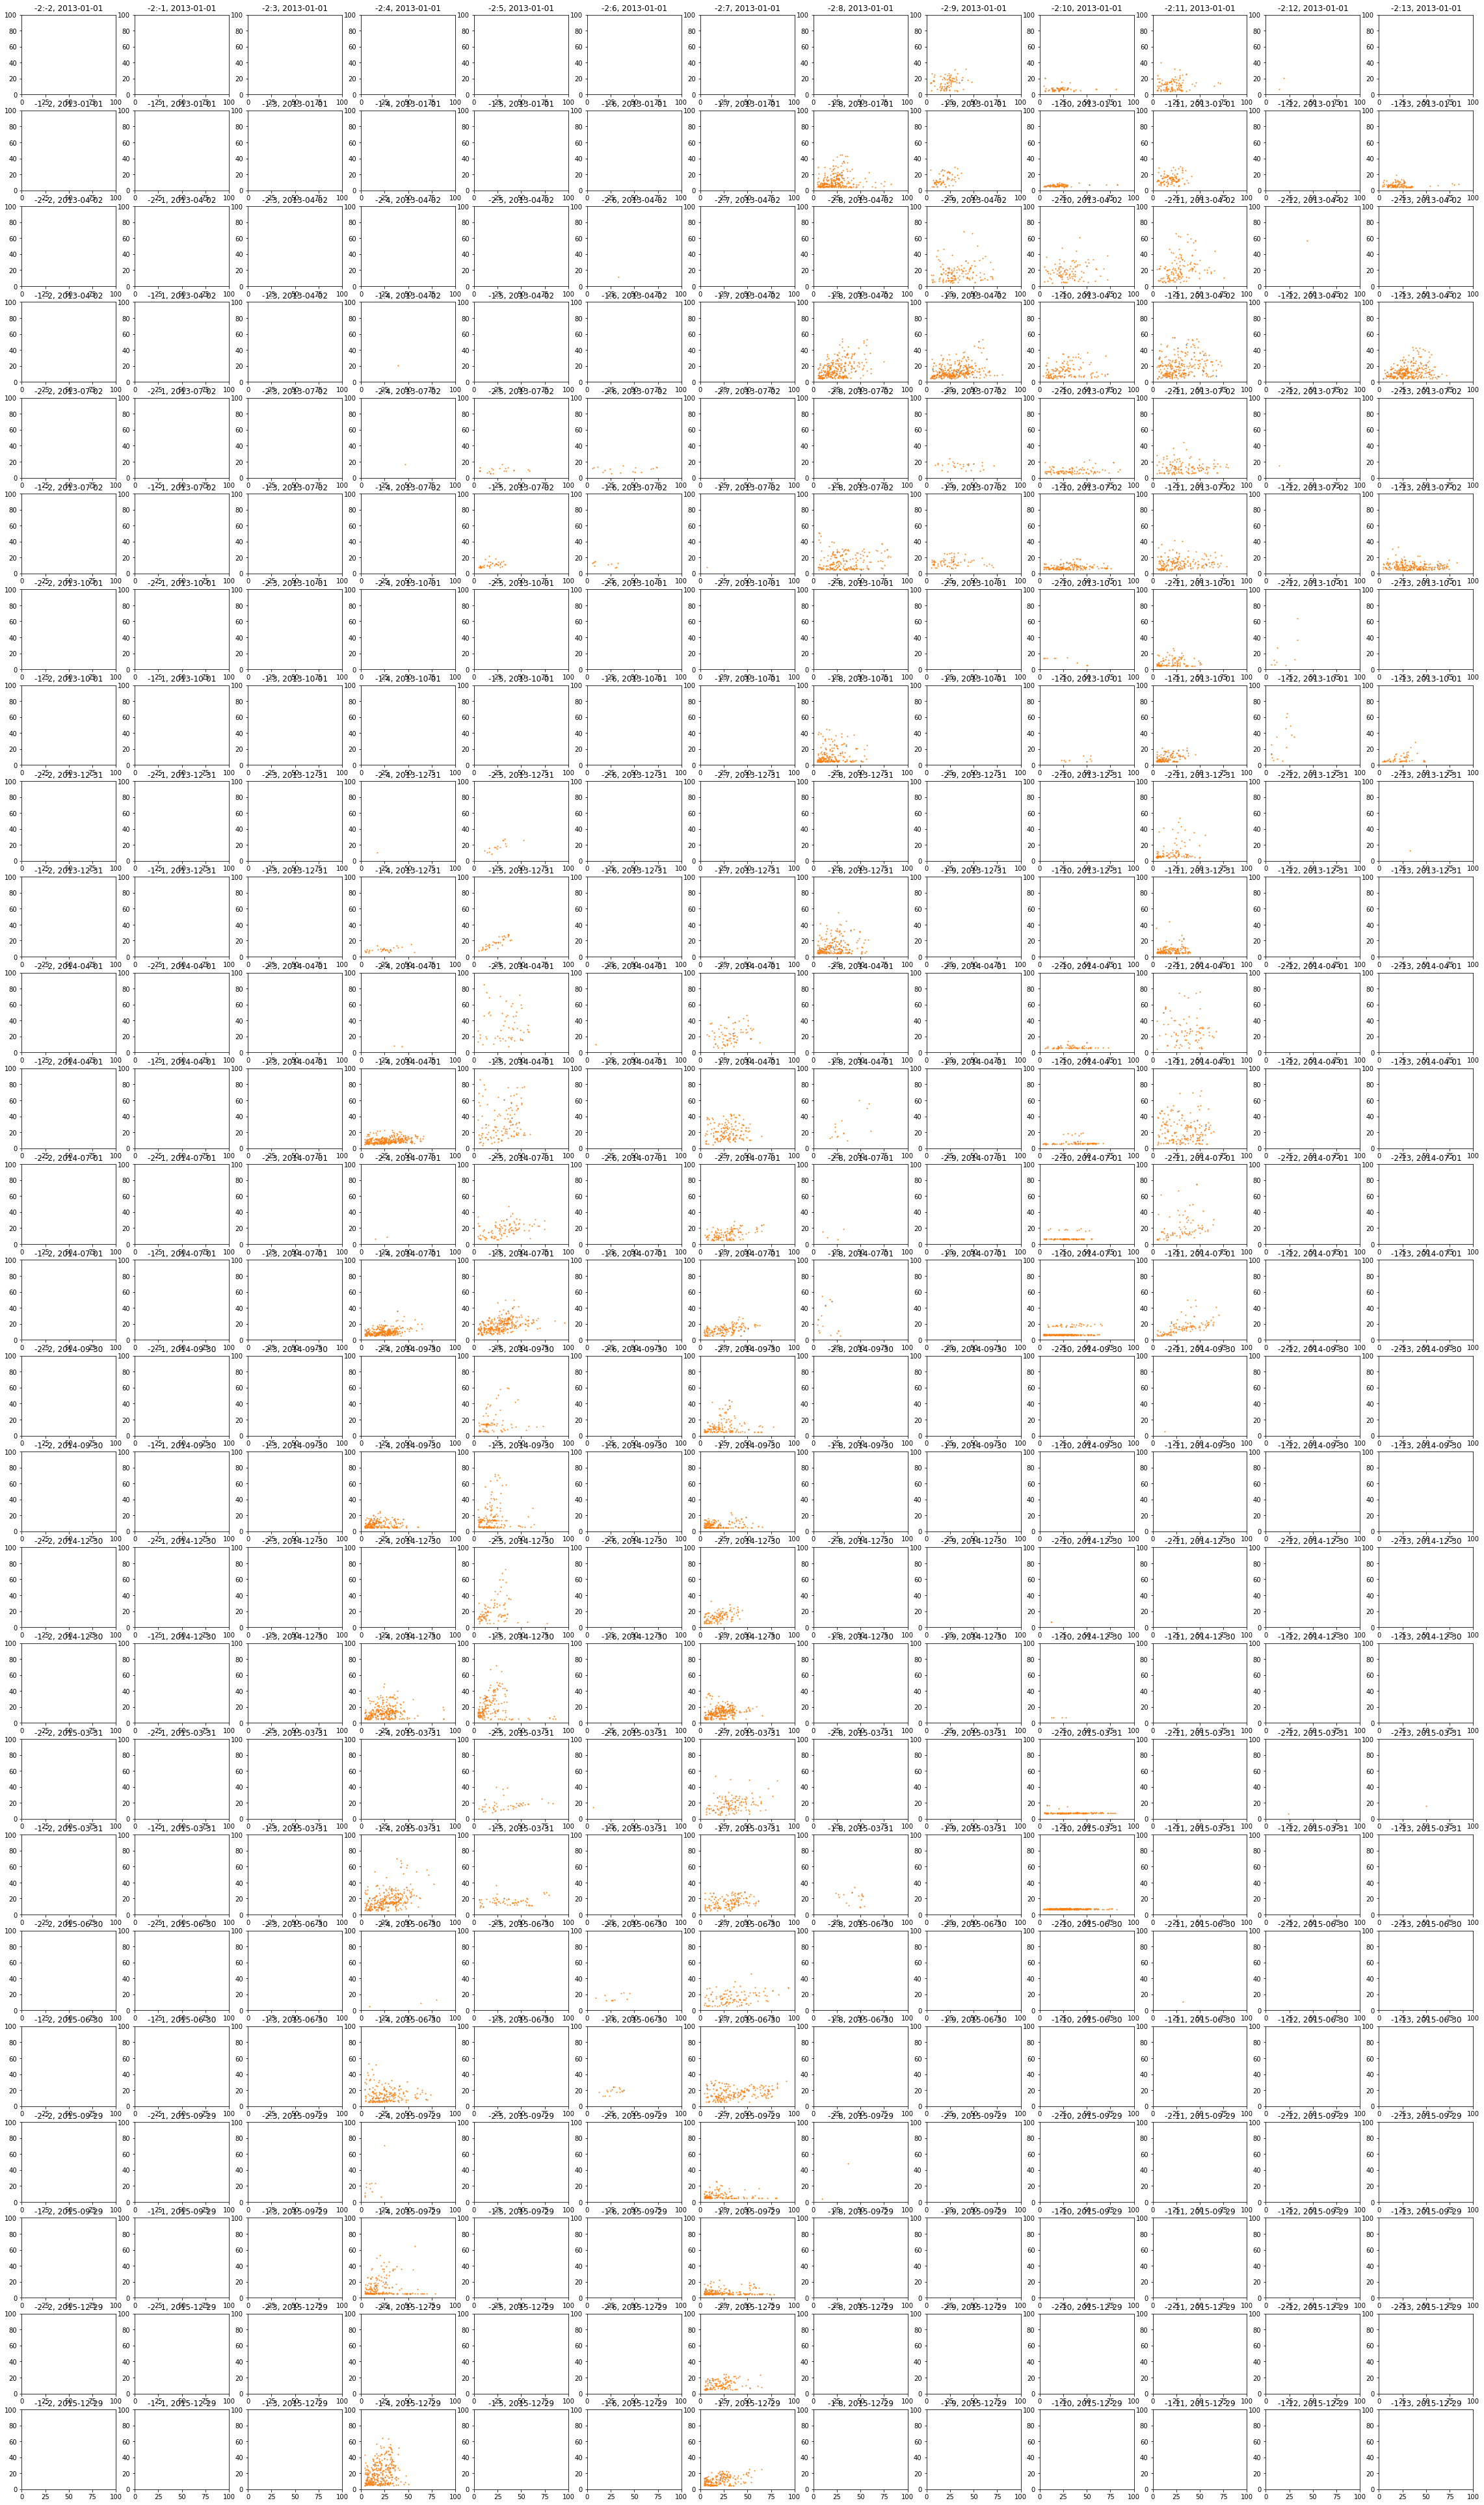

In [7]:
sidAs = sorted(np.unique(encounters['deviceid_sensorA']))
sidBs = sorted(np.unique(encounters['deviceid_sensorB']))

t = np.datetime64('2013-01-01 00:00:01')
dt = np.timedelta64(91*3600*24,'s')
plt.figure(figsize=[40,70])
for tblock in range(13):    
    plti = len(sidAs)*2*tblock+1
    for iA,idA in enumerate(sidAs[:2]):
        for iB,idB in enumerate(sidBs[:]):
            plt.subplot(26,len(sidBs),plti)
            enc = encounters[((encounters['deviceid_sensorA']==idA) & (encounters['deviceid_sensorB']==idB))]
            en = enc[(enc['datetime']>t) & (enc['datetime']<t+dt)]# & (enc['dist']<15)]
            plt.scatter(en['o3_sensorA'],en['o3_sensorB'],1,alpha=1)

            enc = encounters[((encounters['deviceid_sensorB']==idA) & (encounters['deviceid_sensorA']==idB))]
            en = enc[(enc['datetime']>t) & (enc['datetime']<t+dt)]# & (enc['dist']<15)]
            plt.scatter(en['o3_sensorB'],en['o3_sensorA'],1,alpha=1)
            plt.title("%d:%d, %s" % (int(idA),idB,str(t)[:10]))
            plt.xlim([0,100])
            plt.ylim([0,100])
            plti+=1
    t = t + dt

In [8]:
hours = (encounters['datetime']-pd.Timestamp('2012-01-01')).dt.total_seconds()/3600 
encounters['hours'] = hours 
#we shift ids to start at zero, so -2-->0 -1-->1...
X = np.c_[hours,encounters['deviceid_sensorA']+2,encounters['deviceid_sensorB']+2]
Y = np.c_[encounters['o3_sensorA'],encounters['o3_sensorB']]
unq = np.unique(np.r_[np.unique(encounters['deviceid_sensorA']),np.unique(encounters['deviceid_sensorB'])])
#keep = ((X[:,2]>=0) & (X[:,1]>=0))
#Xtest = X[~keep,:]
#Ytest = Y[~keep,:]
#X = X[keep,:]
#Y = Y[keep,:]
#refsensor = unq==-2
refsensor = np.full(1+int(np.max(X[:,1])),False)
refsensor[0]=True
refsensor[1]=True

In [9]:
#unq = np.unique(encounters['deviceid_sensorA'].astype(int))
################################
#FOR PLOTTING we build a network
import networkx as nx
G = nx.DiGraph()
for ia,idA in enumerate(unq):
    for idB in unq[ia:]:
        s = np.sum((encounters['deviceid_sensorA']==idA) & (encounters['deviceid_sensorB']==idB))+np.sum((encounters['deviceid_sensorA']==idB) & (encounters['deviceid_sensorB']==idA))
        if s>20:
            G.add_edge(idA,idB,weight=s)
for e in G.edges:
    G.edges[e]['w']=np.sqrt(G.edges[e]['weight'])


In [10]:
[[e,G.get_edge_data(*e)['weight']] for e in G.edges()]

[[(-2.0, 3.0), 44],
 [(-2.0, 4.0), 43],
 [(-2.0, 5.0), 418],
 [(-2.0, 6.0), 33],
 [(-2.0, 7.0), 1083],
 [(-2.0, 9.0), 268],
 [(-2.0, 10.0), 605],
 [(-2.0, 11.0), 771],
 [(3.0, 8.0), 80],
 [(4.0, 5.0), 3172],
 [(4.0, 6.0), 3438],
 [(4.0, 7.0), 4707],
 [(4.0, 8.0), 3047],
 [(4.0, 9.0), 249],
 [(4.0, 10.0), 2589],
 [(4.0, 11.0), 1439],
 [(4.0, 12.0), 3228],
 [(4.0, 13.0), 2605],
 [(5.0, 6.0), 3611],
 [(5.0, 7.0), 7568],
 [(5.0, 8.0), 3120],
 [(5.0, 9.0), 257],
 [(5.0, 10.0), 3769],
 [(5.0, 11.0), 2998],
 [(5.0, 12.0), 4068],
 [(5.0, 13.0), 2876],
 [(6.0, 7.0), 4769],
 [(6.0, 8.0), 4467],
 [(6.0, 9.0), 358],
 [(6.0, 10.0), 3289],
 [(6.0, 11.0), 2241],
 [(6.0, 12.0), 4849],
 [(6.0, 13.0), 4140],
 [(7.0, 8.0), 3407],
 [(7.0, 9.0), 381],
 [(7.0, 10.0), 5346],
 [(7.0, 11.0), 2878],
 [(7.0, 12.0), 4227],
 [(7.0, 13.0), 3328],
 [(9.0, 10.0), 1715],
 [(9.0, 11.0), 2309],
 [(9.0, 12.0), 302],
 [(9.0, 13.0), 857],
 [(10.0, 11.0), 5632],
 [(10.0, 12.0), 3666],
 [(10.0, 13.0), 4297],
 [(11.0, 12.0), 

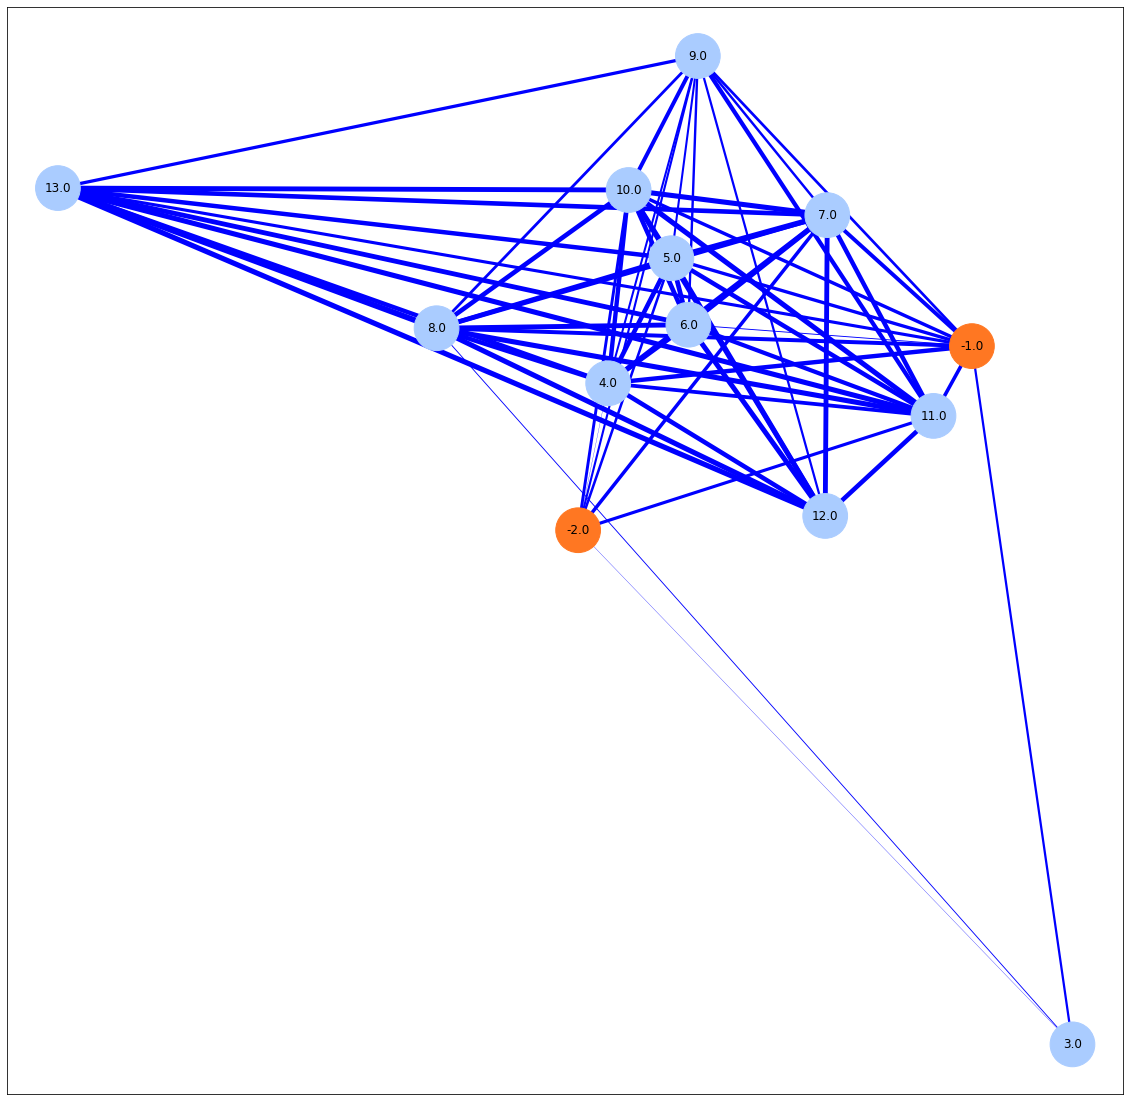

In [11]:
################################
#PLOT THE GRAPH

plt.figure(figsize=[20,20])
weights = np.array([G.get_edge_data(*e)['weight'] for e in G.edges()])
widths = np.log(weights)-np.min(np.log(weights))#(500*weights)/np.max(weights)
#widths[widths>10]=10
#mobile = [np.mean(np.abs(np.diff(df[df['channel_id']==sid]['x'])))>10 for sid in unq]
mobile = [1 if i>0 else 0 for i in unq]

cols = []
for n in G.nodes:
    c = '#99ff99'
    idx = np.where(unq==n)[0][0]
    if refsensor[idx]: c = '#ff7722'
    if mobile[idx]: c = '#aaccff'
    cols.append(c)

nx.draw_networkx(G,pos=nx.spring_layout(G,k=2,weight='w'),arrows=False,width=widths,edge_color='blue',node_color=cols,node_size=2000)
plt.savefig('network.pdf')

In [12]:
encounters['hours']

datetime
2012-02-17 23:30:00     1151.5
2012-04-23 04:30:00     2716.5
2013-09-09 14:30:00    14822.5
2013-09-26 23:30:00    15239.5
2013-09-30 16:00:00    15328.0
                        ...   
2016-09-05 04:30:00    41020.5
2016-09-05 05:30:00    41021.5
2016-09-05 06:00:00    41022.0
2016-09-05 06:30:00    41022.5
2016-09-05 10:30:00    41026.5
Name: hours, Length: 170103, dtype: float64

In [13]:
#OPTION: using 1014687 which is next to 24517 as test sensor.
#temp = []
#for sA,sB in [['B','A'],['A','B']]:
#    tempdf = encounters[(encounters['channel_id_sensor'+sA]==1014687) & (encounters['channel_id_sensor'+sB]==-24517)]
#    tempdf['t'] = (tempdf['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600
#    temp.append(tempdf[['t','pm2_5_sensor'+sA,'pm2_5_sensor'+sB]].to_numpy())
#temp = np.r_[temp[0],temp[1]]
#temp = temp[np.min(temp[:,1:],1)>5,:]
#
#testX = np.c_[temp[:,0],np.full_like(temp[:,0],np.where(unq==1014687)[0][0])]
#testY = temp[:,1:2]
#testtrueY = temp[:,2:3]


In [14]:
encounters

,o3ugm3_sensorA,temperature_static_sensorA,pressure_static_sensorA,E_sensorA,N_sensorA,deviceid_sensorA,o3_sensorA,temperature_sensorA,humidity_sensorA,o3ugm3_sensorB,...,pressure_static_sensorB,E_sensorB,N_sensorB,deviceid_sensorB,o3_sensorB,temperature_sensorB,humidity_sensorB,dist,datetime,hours
datetime,,,,,,,,,,,,,,,,,,,,,
2012-02-17 23:30:00,12.29,1.83,973.70,683146.000000,249020.000000,-2.0,6.009749,NaN,NaN,NaN,...,NaN,683142.934555,249034.744092,3.0,6.50,0.0,59.0,15.059389,2012-02-17 23:30:00,1151.5
2012-04-23 04:30:00,62.92,6.30,959.40,683146.000000,249020.000000,-2.0,31.734046,NaN,NaN,NaN,...,NaN,683149.664561,248974.905278,3.0,14.28,4.0,73.0,45.243375,2012-04-23 04:30:00,2716.5
2013-09-09 14:30:00,80.40,18.57,969.83,683146.000000,249020.000000,-2.0,41.876347,NaN,NaN,NaN,...,NaN,683141.758364,249037.841003,5.0,9.77,13.0,88.0,18.338289,2013-09-09 14:30:00,14822.5
2013-09-26 23:30:00,33.15,16.66,966.12,683146.000000,249020.000000,-2.0,17.218943,NaN,NaN,NaN,...,NaN,683153.775177,249020.997052,5.0,5.25,12.0,100.0,7.838845,2013-09-26 23:30:00,15239.5
2013-09-30 16:00:00,11.63,13.99,957.10,683146.000000,249020.000000,-2.0,6.041638,NaN,NaN,NaN,...,NaN,683139.007905,249029.351704,5.0,8.45,10.0,91.0,11.676633,2013-09-30 16:00:00,15328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-05 04:30:00,NaN,NaN,NaN,684131.865055,246094.077672,13.0,13.440000,12.0,2.0,NaN,...,NaN,684131.213414,246097.404207,12.0,15.92,12.0,100.0,3.389760,2016-09-05 04:30:00,41020.5
2016-09-05 05:30:00,NaN,NaN,NaN,680125.794207,248578.090489,13.0,12.440000,12.0,2.0,NaN,...,NaN,680099.593069,248594.526309,12.0,15.92,12.0,100.0,30.929530,2016-09-05 05:30:00,41021.5
2016-09-05 06:00:00,NaN,NaN,NaN,683999.193427,246291.342396,13.0,12.650000,12.0,2.0,NaN,...,NaN,683991.518174,246326.481757,12.0,15.92,12.0,100.0,35.967822,2016-09-05 06:00:00,41022.0


(array([[ 1023.,     0.,     0.,   358., 31787., 15677., 42638.,  4170.,
         36002., 38448.],
        [13119.,     0.,     0.,   101., 28205., 15610., 38333.,  3562.,
         32960., 38213.]]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 2 Lists of Patches objects>)

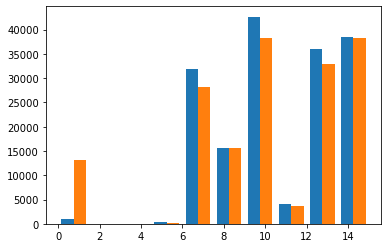

In [15]:
plt.hist(X[:,1:])

In [16]:
hours = (encounters['datetime']-pd.Timestamp('2012-01-01')).dt.total_seconds()/3600 
encounters['hours'] = hours 
#we shift ids to start at zero, so -2-->0 -1-->1...
X = np.c_[hours,encounters['deviceid_sensorA']+2,encounters['deviceid_sensorB']+2]
Y = np.c_[encounters['o3_sensorA'],encounters['o3_sensorB']]
unq = np.unique(np.r_[np.unique(encounters['deviceid_sensorA']),np.unique(encounters['deviceid_sensorB'])])
#keep = ((X[:,2]>=0) & (X[:,1]>=0))
#Xtest = X[~keep,:]
#Ytest = Y[~keep,:]
#X = X[keep,:]
#Y = Y[keep,:]
#refsensor = unq==-2
refsensor = np.full(1+int(np.max(X[:,1])),False)
refsensor[0]=True
refsensor[1]=True


testtarget = 11
testencsA = encounters[((encounters['deviceid_sensorB']==testtarget) & (encounters['deviceid_sensorA']<0))] #
testencsB = encounters[((encounters['deviceid_sensorA']==testtarget) & (encounters['deviceid_sensorB']<0))] #[['seconds','o3_sensorB']].to_numpy()
#testencs = [datetime, true, raw]
testencs = np.r_[testencsA[['hours','o3_sensorA','o3_sensorB']].to_numpy(),testencsB[['hours','o3_sensorB','o3_sensorA']].to_numpy()]
testX = np.c_[testencs[:,0],np.full(len(testencs),testtarget+2)] #have to add 2 to the id
testY = testencs[:,2][:,None]
testtrueY = testencs[:,1][:,None]


keep = (X[:,1]>1) | (X[:,2]!=testtarget+2)
X = X[keep,:]
Y = Y[keep,:]
keep = (X[:,1]!=testtarget+2) | (X[:,2]>1)
X = X[keep,:]
Y = Y[keep,:]


In [17]:
#Y = np.log(Y)
#testY = np.log(testY)
#testtrueY = np.log(testtrueY)

In [18]:
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.synthetic import generate_synthetic_dataset, getstaticsensortranform, getmobilesensortranform
from calibration.simple import compute_simple_calibration, compute_simple_predictions

delta = 100000 #24*90
G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor,mincolocationsinperiod=50,weightovertime=0.1)
preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)


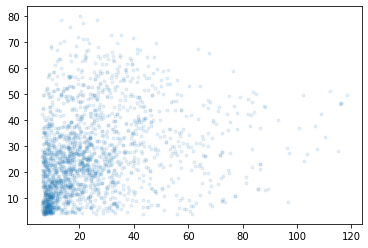

In [19]:
plt.plot(preds,testtrueY,'.',alpha=0.1)

In [20]:
np.c_[preds,testtrueY]

array([[ 8.92101148, 28.6433098 ],
       [ 8.03512707, 21.23926091],
       [ 9.88460505,  8.34662103],
       ...,
       [45.00914503, 64.06882371],
       [27.50904237, 63.80133683],
       [39.92696602, 25.72388737]])

In [24]:
MAE(preds,testtrueY), NMSE(preds,testtrueY)

(15.124224982899102, 1.308978730679962)

In [38]:
np.sqrt(MSE(preds,testtrueY))

21.04189427502236

In [22]:
NMSE(preds,testtrueY)

1.308978730679962

In [23]:
np.mean(np.diff(np.log(Y[(X[:,1]==7) & (X[:,2]==0)]),1))+np.mean(np.diff(np.log(Y[(X[:,1]==testtarget+2) & (X[:,2]==7)]),1))

0.4409501244860642

In [24]:
np.mean(np.log(testtrueY/testY))

0.5418235287909019

In [25]:
MAE(testY*np.exp(0.44095),testtrueY)

15.12422439745088

In [26]:
MAE(testY*np.exp(np.mean(np.log(testtrueY/testY))),testtrueY)

15.738026057749625

In [22]:
MAE(testY,testtrueY),NMSE(testY,testtrueY)

(15.334445433431124, 2.908166456053916)

In [28]:
np.std(testtrueY)

15.816675110426518

In [29]:
np.sum((X[:,1]==testtarget+2) & (X[:,2]==0))

0

In [30]:
testtarget+2

13

In [31]:
allcals

{(0, 0): 0.0,
 (7, 0): 0.24976662271714203,
 (9, 0): 0.6332067450852399,
 (11, 0): 0.6254506057117257,
 (12, 0): 1.1482269531121982,
 (1, 0): 0.0,
 (6, 0): 0.4945178978382767,
 (8, 0): 0.1477545074690215,
 (10, 0): 0.5847123746227907,
 (13, 0): 0.44095012448606413,
 (14, 0): 0.30442920284263625,
 (15, 0): 1.0425762090443111,
 (5, 0): 0.6271961169670441}

In [32]:
from tensorflow_probability import distributions as tfd
from calibration import CalibrationSystem, SparseModel
import gpflow
import tensorflow as tf

#class CalibrationSystemNormalisedLikelihood(CalibrationSystem):    
#    def likelihoodfn(self,scaledA,scaledB,ref):
#        likelihoodstd = np.sqrt((self.likelihoodstd**2)*np.sum(1-ref,1))
#        return tfd.Normal(0,likelihoodstd).log_prob((scaledA-scaledB)/(0.5*(scaledA+scaledB)))
Ttotal = np.max(X[:,0])
Ttotal = 100*int(1+(Ttotal+1)/100)

In [34]:
#keep = (X[:,1]!=13) & (X[:,2]!=13)
#X = X[keep,:]
#Y = Y[keep,:]

In [35]:
ls = 2400 #100 days
kvar = 1
bvar = 1
#runlength = 100
Nind = 30

hstd=0.1
runlength = 100
#for runlength in [500,1000]:
likelihoodstd=10
hstd=10
for randomrestarts in range(10):
    bvar = kvar
    #for bvar in [0.1,0.3]:
    Z = np.linspace(-200,Ttotal+200,Nind)[:,None] ##60
    #def transform_fn(samps,Y,sideY):
    #    return Y*tf.exp(samps[:,:,0:1])

    def transform_fn(samps,Y,sideY):
        return Y*tf.exp(samps[:,:,0:1])
        #return Y*samps[:,:,0:1]

    def transform_fn_loggrad(samps,Y,sideY):
        return samps[:,:,0:1]
        #return tf.math.log(tf.abs(samps[:,:,0:1]))

    kernelindices = [[0]*len(refsensor)]


    #this seems to work ok.
    #k = gpflow.kernels.RBF(9,24*100) + gpflow.kernels.Bias(3)
    k = gpflow.kernels.RBF(kvar,ls)# + gpflow.kernels.Bias(bvar)
    #k = gpflow.kernels.Bias(3)
    #cs = CalibrationSystemNormalisedLikelihood(X, Y, Z, refsensor, 1, transform_fn, [k], kernelindices,lr=0.01,likelihoodstd=np.sqrt(0.2),minibatchsize=100)
    cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, transform_fn_loggrad, [k], kernelindices,lr=0.01,likelihoodstd=likelihoodstd, hstd=hstd, minibatchsize=200)
    import time
    before = time.time()
    print("Starting Run")
    elbo_record = cs.run(runlength,samples=200) ##3000 iterations, 300 samples
    print(time.time()-before)


    #the test matrix is TIME,SENSOR,COMPONENT
    tX = np.c_[testX,np.full(len(testX),0)]
    testsm = SparseModel(tX,cs.Z,1,cs.k)
    #testsm = SparseModel(tX,cs.Z,1,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
    #predY[predY>100]=100

    nlpd = NLPD(np.log(testtrueY[:,0]),np.log(testY[:,0:1])+qf_mu[:,0],np.sqrt(np.diag(qf_cov)))
    keep = ~np.isnan(testtrueY)
    nmse = NMSE(testtrueY[:,0],predY[:,0])
    mse = MSE(testtrueY[:,0],predY[:,0])
    mae = MAE(testtrueY[:,0],predY[:,0])
    #print("kvar = %0.1f, ls = %0.1f, bvar = %0.1f, Nind = %d, runlength = %d: " % (kvar,ls,bvar,Nind,runlength), end="")
    print(likelihoodstd,hstd)
    print("elbo=",elbo_record[-1],"runlength=",runlength,end=" ")
    print("nlpd=%5.2f nmse=%5.5f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Starting Run
37.2054488658905
10 10
elbo= 1922239.8 runlength= 100 nlpd= 1.71 nmse=1.70792 mse=427.26 mae=15.35
Starting Run
35.87162160873413
10 10
elbo= 1915115.1 runlength= 100 nlpd= 1.52 nmse=1.59997 mse=400.26 mae=14.93
Starting Run
38.013145446777344
10 10
elbo= 1926188.2 runlength= 100 nlpd= 1.54 nmse=1.67477 mse=418.97 mae=15.27
Starting Run
33.29394507408142
10 10
elbo= 1917823.1 runlength= 100 nlpd= 1.50 nmse=1.58886 mse=397.48 mae=15.06
Starting Run
35.99119853973389
10 10
elbo= 1929952.5 runlength= 100 nlpd= 1.53 nmse=1.70680 mse=426.99 mae=15.69
Starting Run
37.128018856048584
10 10
elbo= 1923840.0 runlength= 100 nlpd= 1.48 nmse=1.58854 mse=397.40 mae=14.85
Starting Run
36.78542876243591
10 10
elbo= 1916580.1 runlength= 100 nlpd= 1.53 nmse=1.52495 mse=381.49 mae=14.80
Starting Run
36.14215874671936
10 

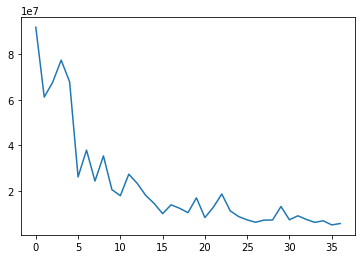

In [48]:
plt.plot(elbo_record)


In [ ]:
Starting Run
43.92459964752197
elbo= 41444560000.0 runlength= 100 nlpd= 1.60 nmse=1.80023 mse=450.36 mae=15.51
Starting Run
44.04113817214966
elbo= 35083070000.0 runlength= 100 nlpd= 1.64 nmse=2.57562 mse=644.34 mae=17.06
Starting Run
43.71788430213928
elbo= 31125684000.0 runlength= 100 nlpd= 1.62 nmse=2.19080 mse=548.07 mae=15.97
Starting Run
43.58221626281738
elbo= 38130120000.0 runlength= 100 nlpd= 1.64 nmse=2.06954 mse=517.73 mae=16.10
Starting Run
43.560227155685425
elbo= 38453953000.0 runlength= 100 nlpd= 1.74 nmse=1.96884 mse=492.54 mae=15.01
Starting Run
43.728358030319214
elbo= 34817925000.0 runlength= 100 nlpd= 1.79 nmse=2.41873 mse=605.09 mae=16.37
Starting Run
43.83413767814636
elbo= 37417190000.0 runlength= 100 nlpd= 1.66 nmse=3.00981 mse=752.96 mae=17.92
Starting Run
43.72147297859192
elbo= 32195226000.0 runlength= 100 nlpd= 1.66 nmse=2.86033 mse=715.56 mae=17.27
Starting Run
43.93214130401611
elbo= 45136430000.0 runlength= 100 nlpd= 1.63 nmse=2.14936 mse=537.70 mae=15.83
Starting Run
43.664289236068726
elbo= 40662348000.0 runlength= 100 nlpd= 1.82 nmse=1.88640 mse=471.92 mae=15.39
Starting Run
43.90313243865967
elbo= 34944530000.0 runlength= 100 nlpd= 1.61 nmse=3.47937 mse=870.42 mae=18.66
Starting Run
43.672701597213745
elbo= 52625637000.0 runlength= 100 nlpd= 1.75 nmse=2.75031 mse=688.04 mae=17.50
Starting Run
43.93172001838684
elbo= 31840014000.0 runlength= 100 nlpd= 1.74 nmse=2.18804 mse=547.37 mae=16.18
Starting Run
43.71253776550293
elbo= 39974875000.0 runlength= 100 nlpd= 1.58 nmse=2.49998 mse=625.41 mae=16.95
Starting Run
44.22131085395813
elbo= 43160060000.0 runlength= 100 nlpd= 1.62 nmse=2.27360 mse=568.78 mae=17.40
Starting Run
43.81125569343567
elbo= 35266073000.0 runlength= 100 nlpd= 1.62 nmse=2.68988 mse=672.92 mae=17.10
Starting Run
44.06254005432129
elbo= 45710143000.0 runlength= 100 nlpd= 1.67 nmse=2.80765 mse=702.38 mae=16.81
Starting Run
43.84421896934509
elbo= 27084253000.0 runlength= 100 nlpd= 1.62 nmse=3.13985 mse=785.49 mae=19.00
Starting Run
43.695927143096924
elbo= 40697690000.0 runlength= 100 nlpd= 1.56 nmse=3.47177 mse=868.52 mae=18.38
Starting Run
44.155943632125854
elbo= 58732823000.0 runlength= 100 nlpd= 1.51 nmse=3.62148 mse=905.98 mae=19.59
Starting Run
219.0580735206604
elbo= 11250468000.0 runlength= 500 nlpd= 1.99 nmse=2.19654 mse=549.50 mae=16.14
Starting Run
219.16059708595276
elbo= 8555944000.0 runlength= 500 nlpd= 2.13 nmse=2.05638 mse=514.44 mae=15.50
Starting Run
219.25810766220093
elbo= 10340427000.0 runlength= 500 nlpd= 2.43 nmse=1.75232 mse=438.37 mae=15.35
Starting Run
219.24777960777283
elbo= 13500764000.0 runlength= 500 nlpd= 2.18 nmse=2.62898 mse=657.68 mae=16.92
Starting Run
219.69960832595825
elbo= 11196990000.0 runlength= 500 nlpd= 2.32 nmse=1.92383 mse=481.28 mae=15.86
Starting Run
220.10753798484802
elbo= 9022379000.0 runlength= 500 nlpd= 1.76 nmse=2.57250 mse=643.56 mae=17.16
Starting Run
219.74047827720642
elbo= 8386546000.0 runlength= 500 nlpd= 2.20 nmse=1.75894 mse=440.03 mae=14.92
Starting Run
219.6546266078949
elbo= 12948356000.0 runlength= 500 nlpd= 1.79 nmse=1.82468 mse=456.47 mae=15.44
Starting Run
220.3764772415161
elbo= 7487390700.0 runlength= 500 nlpd= 2.15 nmse=1.73675 mse=434.48 mae=15.42
Starting Run
220.50738334655762
elbo= 7617508000.0 runlength= 500 nlpd= 1.96 nmse=1.95341 mse=488.68 mae=15.77
Starting Run
220.2453088760376
elbo= 7770912300.0 runlength= 500 nlpd= 3.00 nmse=1.66890 mse=417.50 mae=15.13
Starting Run
220.12030601501465
elbo= 11546769000.0 runlength= 500 nlpd= 2.13 nmse=2.07013 mse=517.88 mae=15.63
Starting Run
220.03651595115662
elbo= 12216948000.0 runlength= 500 nlpd= 1.79 nmse=2.41487 mse=604.12 mae=16.48
Starting Run
219.76603770256042
elbo= 11802960000.0 runlength= 500 nlpd= 2.47 nmse=1.69259 mse=423.43 mae=15.26
Starting Run
219.7012219429016
elbo= 12035594000.0 runlength= 500 nlpd= 1.99 nmse=2.61848 mse=655.06 mae=18.28
Starting Run
219.49810218811035
elbo= 12351747000.0 runlength= 500 nlpd= 1.73 nmse=2.08990 mse=522.82 mae=16.00
Starting Run
219.5536971092224
elbo= 8719603000.0 runlength= 500 nlpd= 1.98 nmse=2.54837 mse=637.52 mae=17.16
Starting Run
220.37057185173035
elbo= 7759452700.0 runlength= 500 nlpd= 2.53 nmse=1.64084 mse=410.48 mae=15.02
Starting Run
219.70706868171692
elbo= 9387876000.0 runlength= 500 nlpd= 2.36 nmse=1.86858 mse=467.46 mae=15.37
Starting Run
220.8304853439331
elbo= 12283060000.0 runlength= 500 nlpd= 2.15 nmse=2.09526 mse=524.16 mae=15.98

In [ ]:
43047200000.0
nlpd= 1.78 nmse=2.57020 mse=642.98 mae=17.00
29909010000.0
nlpd= 1.77 nmse=1.52657 mse=381.90 mae=14.75

In [ ]:
Starting Run
173.04097366333008
nlpd= 2.52 nmse=1.53153 mse=383.14 mae=14.64
Starting Run
177.6254096031189
nlpd= 2.04 nmse=1.92064 mse=elbo_record[-1]480.48 mae=15.62
Starting Run
176.96456122398376
nlpd= 2.20 nmse=1.74281 mse=435.99 mae=15.56
Starting Run
180.50477719306946
nlpd= 2.21 nmse=2.55308 mse=638.70 mae=17.36
Starting Run
179.9219686985016
nlpd= 1.73 nmse=2.39556 mse=599.29 mae=17.05
Starting Run
182.444153547287
nlpd= 2.19 nmse=1.64063 mse=410.43 mae=14.83
Starting Run
191.26727199554443
nlpd= 2.27 nmse=1.59481 mse=398.97 mae=14.54
Starting Run
175.13242411613464
nlpd= 1.87 nmse=1.78019 mse=445.35 mae=15.59
Starting Run
179.7439227104187
nlpd= 2.65 nmse=1.96473 mse=491.51 mae=16.20
Starting Run
167.82968616485596
nlpd= 2.47 nmse=1.88009 mse=470.34 mae=15.38

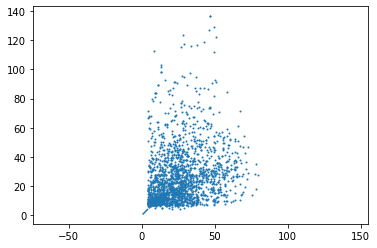

In [48]:
#plt.scatter(testY,testtrueY,1)
plt.scatter(testtrueY,predY,1)
plt.axis('equal')
plt.plot([1,4],[1,4])
#plt.xlim([1,5])
#plt.ylim([1,5])

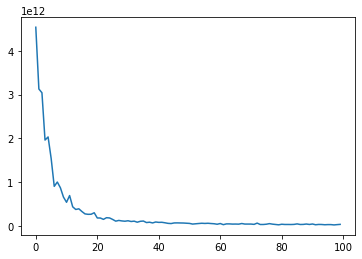

In [54]:
plt.plot(elbo_record)

In [ ]:
C = 1
for si,refs in enumerate(refsensor):
    x = np.linspace(0,Ttotal,160)
    plottestX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        plottestX = np.r_[plottestX,tempX]#.astype(int)
    testsm = SparseModel(plottestX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.title([si,refs])
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-',lw=4)
    plt.plot(x,1/np.exp(samps[:,:,0].numpy().T),'k.',alpha=0.01);
    
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    #senseX = (X[:,1]==si)# & (X[:,2]<Nrefs)
    #plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg',markersize=7,mew=3) 
    #senseX = (X[:,2]==si)# & (X[:,1]<Nrefs)
    #plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg',markersize=7,mew=3)
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=3)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=3)    
    #plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,4])
    plt.grid()
    plt.ylabel('Scaling')
    plt.xlabel('Time / hours')
    #plt.xlim([500,4300])
    #plt.plot(x,(1+(x-1590)/2000),'r-',lw=2)
#plt.savefig('timeseries_variational_kampala.pdf')

In [212]:
np.sum(X[:,1]==13)

0